# Gene enrichment on BRICK
This is an example for GeneSet Enrichment based on BRICK. Generally speaking, the gene sets obtained from omics analysis are overly redundant gene sets, and the genes in them are also heterogeneous in function. BRICK can group genes according to their functions and expression levels in omics data. While indicating the associated entities of the gene sets, it further resolves the heterogeneity of genes in function.

## Loading Packages and Data

In [1]:
import scanpy as sc
import pandas as pd
import BRICK


In [2]:
url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

In [3]:
adata = sc.read('../KG_annotation/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()
sc.tl.rank_genes_groups(adata, groupby='KGannotator_refinement', pts=True)

adata

AnnData object with n_obs × n_vars = 822 × 14821
    obs: 'sample_name', 'n_genes', 'n_counts', 'annotation', 'leiden', 'KGannotator2', 'delta_specific', 'gamma_specific', 'leiden_combined', 'KGannotator_refinement'
    var: 'Ensembl_id', 'Symbol', 'NCBI_id', 'MGI_id', 'mean', 'std'
    uns: 'KGannotator2_colors', 'KGannotator_refinement_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotation_au'
    varm: 'PCs'
    layers: 'lognorm'
    obsp: 'connectivities', 'distances'

## Get Gene Set to Enrich

Here we take pancreatic PP cell as an example, and use top 100 genes to enrich.

In [5]:
BRICK.pp.rank_genes_groups2df(adata)
genelist = list(adata.uns['rank_genes_groups_df']['pancreatic PP cell']['names'])[:100]

In [6]:
# query entities related to genelist. To check available relation type, call: BRICK.help.check_relation_type(source_entity_type='Gene')
query_df = BRICK.qr.query_neighbor(genelist, 
                                   target_entity_type=['Cell', 'Tissue', 'Disease','Phenotype', 
                                                       'Chemical',  'Process', 'Function', 
                                                       'Cell_Component', 'Pathway'], 
                                   relation=['marker_of', 'participate_in', 'causally_related_to', 
                                             'capable_of','spatially_related_to	', 'processly_related_to',
                                             'functionally_related_to', 'has_disease_phenotype_on',
                                             'pharmaco_effect_on'])

# rank target entities based on query result.
query_target_df = BRICK.rk.enrich(query_df)

query_target_df.head()

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
0,[Lpl],[capable_of],[1],[nan],GO:0052740,1-acyl-2-lysophosphatidylserine acylhydrolase ...,Function,1,18,0.090373
1,"[Aplp1, Cpe, Gnas, Cnot6l]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 1, 1]","[[1], [1], [1], [1]]",EMAPA:36041,1-cell stage conceptus,Tissue,4,640,0.397767
2,"[Meg3, Pcsk1n, Ace2]","[marker_of, marker_of, marker_of]","[1, 1, 1]","[[1], [1], [1]]",EMAPA:16033,1-cell stage embryo,Tissue,3,322,0.221572
3,"[Mbnl2, Isl1, Meis2, Maged1]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 1, 1]","[[1], [1], [1], [1]]",UBERON:0007237,1st arch mandibular component,Tissue,4,253,0.041631
4,[Isl1],[marker_of],[2],"[[1, 1]]",UBERON:0013155,1st arch mandibular ectoderm,Tissue,1,42,0.192845


filter target entity with p value cut off as 0.05

In [7]:
query_target_df_sub = query_target_df.loc[query_target_df['pvalue'] < 0.05]

## Cluster genes according to gene functions and visualize 

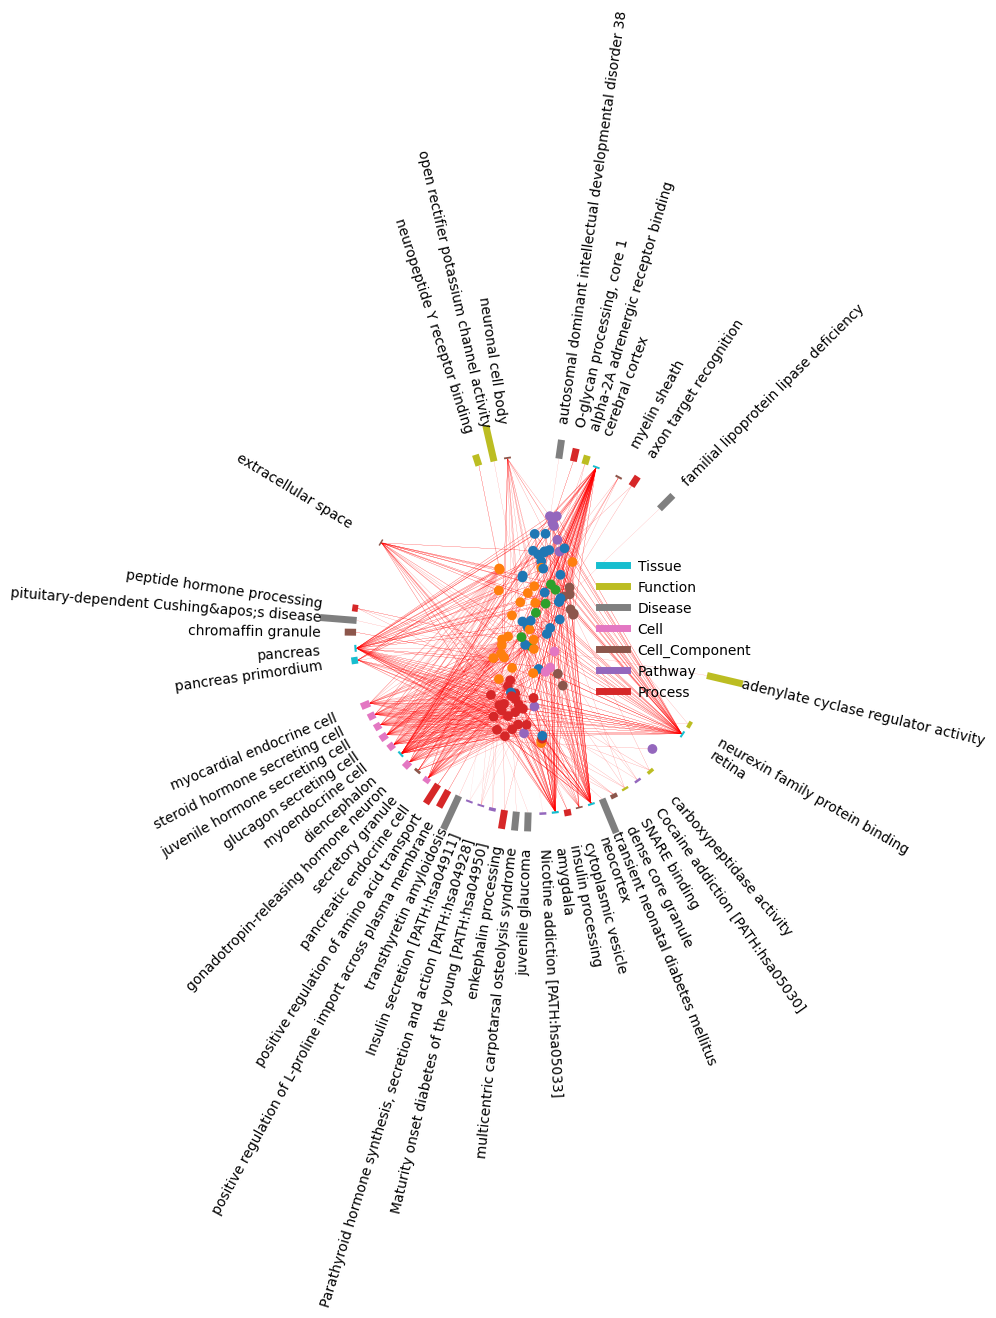

In [8]:
fig, gene_cluster = BRICK.pl.radial_enrich_plot(query_target_df_sub, return_cluster_result=True)

In [9]:
gene_cluster.obs.head()

,leiden
gene,
Meis2,0
Agfg1,1
Gcg,1
Eef1a2,5
Scg5,1


## cluster genes with Omics data by representation learning  

### use representive learning to get gene embedding

(T): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.18it/s, loss=8.46]


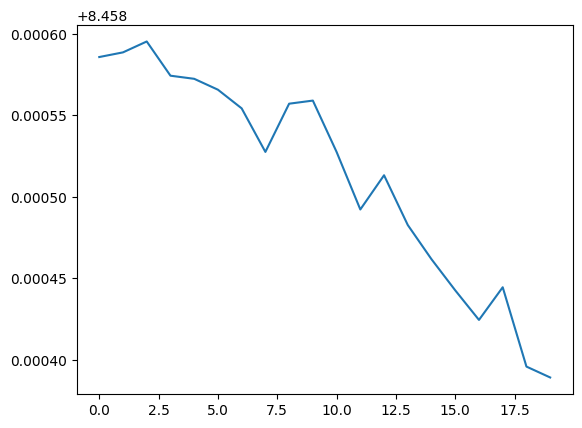

In [10]:
adata_sub = adata[:, genelist]
nxg = BRICK.pp.combine_graph(adata_sub, query_target_df_sub)


model = BRICK.emb.GRACE_model(nxg)
model.fit(20)
model.plot_loss()

In [11]:
adata_graph = model.get_result()
adata_graph 

D:\Anaconda\envs\LLM\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2358 × 32
    obs: 'name', 'type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


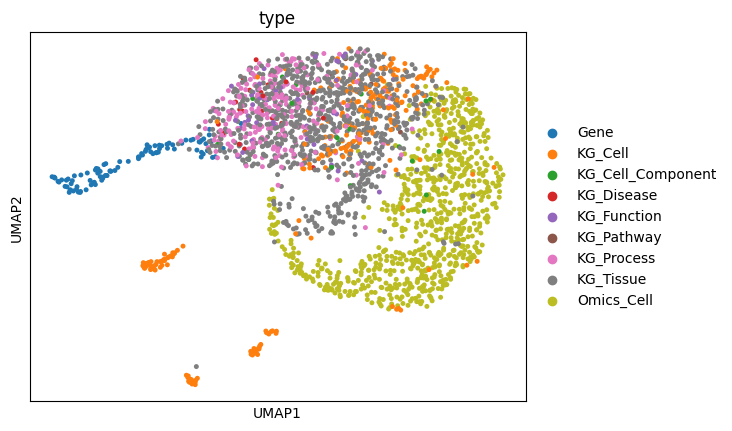

In [12]:
sc.pl.umap(adata_graph, color = 'type')

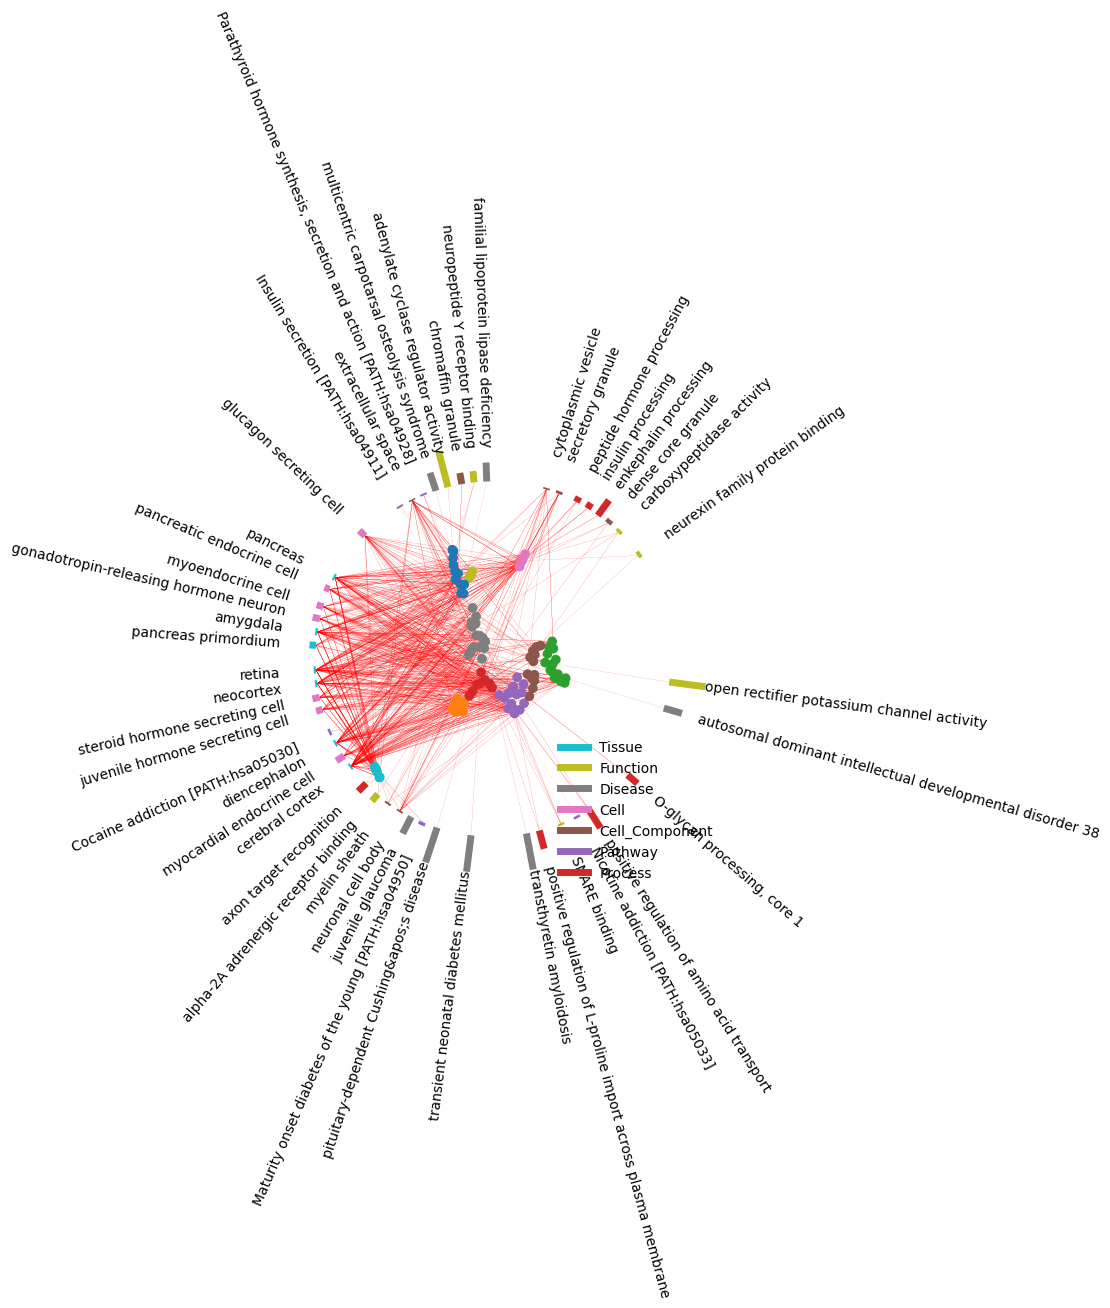

In [14]:
fig, gene_cluster = BRICK.pl.radial_enrich_plot(query_target_df_sub, adata_graph=adata_graph, return_cluster_result=True)